# Sentiment Analysis
-------

This a project to solve a classification problem from NLP, with the goal of identifying positive, negative and neural comments. For that, I expose in this notebook the comparison of two models, a traditional perspective with vectorization and a linear model such as a SVM versus a Neural Networks model.

-------
Aurora Cobo Aguilera

14th July 2023

-------

The first cells have the goal of installing and loading some packages from python nedeed to solve the task following my proposal solution.

In [ ]:
!pip install --upgrade spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.4
    Uninstalling spacy-3.5.4:
      Successfully uninstalled spacy-3.5.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.6.0 which is incompatible.


In [ ]:
!pip install --upgrade gensim

In [ ]:
!python -m spacy download en_core_web_md

2023-07-13 14:38:44.085415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 14:38:48.070975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [1]:
!pip install transformers
!pip install torch
!pip install torchtext

In [2]:
# import libraries
import pandas as pd
import numpy as np
import spacy
import gensim
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense, corpus2csc
from gensim.models.phrases import Phraser, Phrases
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torchtext import data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Mount drive to load the data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## 1. Understanding the data

The first step in the project is to load the data and know more about it.

You may change the *path* according to your drive in order to load it:

In [29]:
# Load the data
path = '/content/drive/MyDrive/Colab Notebooks/Interview citibeats/data/'
path_models = '/content/drive/MyDrive/Colab Notebooks/Interview citibeats/models/'
train_file = 'Sentiment140-train.csv'
test_file = 'Sentiment140-test.csv'
test_file_dublin = 'citypulse.dublin_city_council.test.csv'

# Create dataframes from the data files
df_train = pd.read_csv(path + train_file, encoding='latin-1', header=None)
df_test = pd.read_csv(path + test_file, encoding='latin-1', header=None)
df_test_dublin = pd.read_csv(path + test_file_dublin, encoding='latin-1')

Then, I obtain basic information to check if there are missing values or visible errors. Here, I also detect the first issue I will have to deal regarding the high quantity of data, 1600000 samples.

In [5]:
# Obtain information from the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df_train.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       498 non-null    int64 
 1   1       498 non-null    int64 
 2   2       498 non-null    object
 3   3       498 non-null    object
 4   4       498 non-null    object
 5   5       498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [8]:
df_test.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [9]:
df_test_dublin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_str      3000 non-null   int64  
 1   text        3000 non-null   object 
 2   created_at  3000 non-null   object 
 3   user        0 non-null      float64
 4   sentiment   3000 non-null   object 
 5   category    3000 non-null   object 
 6   dataset     3000 non-null   object 
 7   id          3000 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 187.6+ KB


In [10]:
df_test_dublin.head()

,id_str,text,created_at,user,sentiment,category,dataset,id
0,1190647458608635904,@DanMulhall @EamonnMallie @MoLI_Museum .@DubCi...,2019-11-02T15:10:49+00:00,NaN,positive,Public Spaces,Dublin City,1678054821
1,1136601736016224256,Love my city and community!! Rallying together...,2019-06-06T11:52:25+00:00,NaN,positive,Community and Culture,Dublin City,810929040
2,1180110345052012545,Bringing shared #micromobility e-bike &amp; e-...,2019-10-04T13:20:06+00:00,NaN,positive,Mobility,Dublin City,1650368993
3,1185632195664330752,@rothairisbeoir @__kbaker__ @cullen_ellen @wil...,2019-10-19T19:01:58+00:00,NaN,positive,Mobility,Dublin City,1657921807
4,1162620823682932737,@OConnorOisin @TUDublinEPS @IrishPedestrian @L...,2019-08-17T07:02:59+00:00,NaN,positive,Mobility,Dublin City,1514423883


The proposed columns to be used as input data in the ML models are the tweet text and the label, except for the Dublin test set where it is informative to take also the category column with the interest in some future report elaboration and research questions.

However, in a real scenario, I might use other columns. Explore is the user commenting are repeated and see if some user tend to make negative or positive comments as a rule. The date is always informative too, looking at the week day or if it coincide with any festive where people might be more positive.

In [11]:
df_train[0].value_counts()

0    800000
4    800000
Name: 0, dtype: int64

In [12]:
df_test[0].value_counts()

4    182
0    177
2    139
Name: 0, dtype: int64

In [13]:
df_test_dublin['sentiment'].value_counts()

positive    1000
negative    1000
neutral     1000
Name: sentiment, dtype: int64

We have an issue related to the labels because we distinguish two labels in training and 3 in test, that we will need to deal in any way. However, we do not have an imbalanced problem, so that's good.

## 2. Data preparation

I am going to separate X e Y in the data with interest to train any ML model. X is the observed inputs and Y is the objective output. The category information will be used in the last part.

In [14]:
# Separate X and Y in the data
X_train = df_train[5]
X_test = df_test[5]
X_test_dublin = df_test_dublin['text']

Y_train = df_train[0]
Y_test = df_test[0]
Y_test_dublin = df_test_dublin['sentiment']
category_test_dublin = df_test_dublin['category']

I make a codification in the labels to 0, 1 and 2 respectively to negative, positive and neutral labels.

In [15]:
Y_train.replace(4, 1, inplace=True)
Y_test.replace(4, 1, inplace=True)
Y_test_dublin.replace('negative', 0, inplace=True)
Y_test_dublin.replace('positive', 1, inplace=True)
Y_test_dublin.replace('neutral', 2, inplace=True)

In [16]:
category_test_dublin.value_counts()

Mobility                    669
Community and Culture       614
Housing                     258
Safety                      238
Poverty and Homelessness    236
Environment                 218
Infrastructure              153
Governance                  144
Tourism and Hospitality     120
Social Inclusion             79
Utilities                    74
Education                    69
Economic Development         50
Public Spaces                49
Health                       29
Name: category, dtype: int64

## 3. Baseline model: TFIDF + Linear Classifier

In this first part with the NLP classification challenge, I am going to fit a traditional pipeline where first I have to make a vectorization step and then choose a linear model to classify the vectorized inputs.

### 3.1. Vectorization: TF-IDF

The **vectorization** is a step which consists on creating an embedding representation from each input text, that is, a vectorial representation of the inputs in a low dimensional space. This is a classical technique in sparse data with very high dimension as in NLP with a words vocabulary quite extensive.

The goal of the **TF-IDF vectorization** is to obtain a low dimensional representation of the text input data that captures semantic properties. Even though I have to use TF-IDF, there are other vectorization models such as Word2Vec, Glove, FastText, CBoW or Doc2Vec that we could try.

The fisrt step in the TF-IDF process is to load a pretrained model in Spacy to clean the data. I am reducing the number of samples from the initial quantity because of limitation of resources. I choose from sample 799000 to 801000 so I create a new smaller dataset but with balanced classes. In the original one, the first half was from one class and the other half from another.

In [ ]:
# Load the spaCy English language model
nlp = spacy.load("en_core_web_md")

# Process each document separately and convert to spacy.docs type
doc_train = [nlp(document) for document in X_train.iloc[799000:801000]]    # limitation to being able to compute with the limited resources I have
Y_train = Y_train.iloc[799000:801000] # limitation to being able to compute with the limited resources I have
#doc_train = [nlp(document) for document in X_train]
doc_test = [nlp(document) for document in X_test]
doc_test_dublin = [nlp(document) for document in X_test_dublin]

Then, I filter the text data, removing stopwords (common repeated words without importance) and punctuation and keeping only alphanumeric caracters. Take into account that having a sentiment analysis problem, data such as emoticons can be very valuable. Due to time limit, I am not exploring to incorporate emoticons parsers.

In [ ]:
# Filter tokens of each sentence, removing stop words, punctuations, and tokens without word embedding
norm_doc_train = [[w for w in s if not w.is_stop and w.has_vector and not w.is_punct and (w.is_alpha or w.is_digit)] for s in doc_train]
norm_doc_test = [[w for w in s if not w.is_stop and w.has_vector and not w.is_punct and (w.is_alpha or w.is_digit)] for s in doc_test]
norm_doc_test_dublin = [[w for w in s if not w.is_stop and w.has_vector and not w.is_punct and (w.is_alpha or w.is_digit)] for s in doc_test_dublin]

I convert everything to lowercase in order to create the dictionary.

In [ ]:
# Change to text format (to combine with gensim library)
norm_doc_text_train = [[w.text.lower() for w in s] for s in norm_doc_train]
norm_doc_text_test = [[w.text.lower() for w in s] for s in norm_doc_test]
norm_doc_text_test_dublin = [[w.text.lower() for w in s] for s in norm_doc_test_dublin]

In [ ]:
print(f"There is a total of {len(norm_doc_text_train)} text inputs in the training set.")
print(f"There is a total of {len(norm_doc_text_test)} text inputs in the test set.")
print(f"There is a total of {len(norm_doc_text_test_dublin)} text inputs in the out of domain test set.")

There is a total of 2000 text inputs in the training set.
There is a total of 498 text inputs in the test set.
There is a total of 3000 text inputs in the out of domain test set.


I also include common bi o tri grammars for the dictionary creation.

In [ ]:
# Detect and include more frequent bi/tri grammars
phrase_model = Phrases(norm_doc_text_train)

norm_doc_text_phrases_train = list(phrase_model[norm_doc_text_train])
norm_doc_text_phrases_test = list(phrase_model[norm_doc_text_test])
norm_doc_text_phrases_test_dublin = list(phrase_model[norm_doc_text_test_dublin])

After all the token preprocessing, it is fine to create a dictionary regarding the trianing set. Remember you can not use test data in this step not to fool the mode. Some hyperparameter in the dictionary could be finetuned in a better way with some experiments. I did not follow that exploration.

In [ ]:
# Create the dictionary
D = gensim.corpora.Dictionary(norm_doc_text_phrases_train)

n_tokens = len(D)

# Parameters to filter the tokens
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .8 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below, no_above=no_above)

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 450 terms
First terms in the dictionary:
0 : live
1 : music
2 : wish
3 : angel
4 : charlie
5 : lost
6 : m
7 : sad
8 : today
9 : bored


Having so few tokens in the dictionary might be due to all the cleaning and the 2000 comments I keep. Using all training samples would create a bigger dictionary and more complete.

Finally, I obtain the BoW representation and the TF-IDF one with this last one step.

In [ ]:
# Obtain the BoW representation
bow_train = [D.doc2bow(doc) for doc in norm_doc_text_phrases_train]
bow_test = [D.doc2bow(doc) for doc in norm_doc_text_phrases_test]
bow_test_dublin = [D.doc2bow(doc) for doc in norm_doc_text_phrases_test_dublin]

# Create the TF-IDF model
model = TfidfModel(bow_train)

# Obtain the TF-IDF representation of the data
tfidf_train = model[bow_train]
tfidf_test = model[bow_test]
tfidf_test_dublin = model[bow_test_dublin]

n_tokens = len(D)
num_docs = len(bow_train)

# Convert TFIDF representation
tfidf_dense_train = corpus2dense(tfidf_train, num_terms=n_tokens, num_docs=num_docs).T
tfidf_dense_test = corpus2dense(tfidf_test , num_terms=n_tokens, num_docs=len(bow_test)).T
tfidf_dense_test_dublin = corpus2dense(tfidf_test_dublin , num_terms=n_tokens, num_docs=len(bow_test_dublin)).T

print(f"The dimension in the TF-IDF matrix is {tfidf_dense_train.shape[0]} x {tfidf_dense_train.shape[1]} in the train set.")
print(f"The dimension in the TF-IDF matrix is {tfidf_dense_test.shape[0]} x {tfidf_dense_test.shape[1]} in the test set.")
print(f"The dimension in the TF-IDF matrix is {tfidf_dense_test_dublin.shape[0]} x {tfidf_dense_test_dublin.shape[1]} in the out of domain test set.")

The dimension in the TF-IDF matrix is 2000 x 450 in the train set.
The dimension in the TF-IDF matrix is 498 x 450 in the test set.
The dimension in the TF-IDF matrix is 3000 x 450 in the out of domain test set.


With the TF-IDF matrix, it is possible now to train any traditional classification model such as Logistic Regression o SVMs.

### 3.2. Classification model: Logistic Regression

Here we use a Logistic Regression as the classifier. We use Cross validation to avoid overfitting and explore the possible values in the hiperparameters in a better way.

Ideally, it is better to perform a cross-validation strategy with a smaler step in the exploration range of the hiperparameters. However, again, due to time and resources limitation, we are keeping it simple.

In [ ]:
range_C = np.logspace(-3, 3, 20)
param_grid = [{'C': range_C}]
nfold = 5 # Number of folds in the cross-validation process

""" Adjust C by CV"""
LR_with_CV_tfidf  = GridSearchCV(estimator=LogisticRegression(penalty='L2'), param_grid=param_grid, cv=nfold)

# Train the model
LR_with_CV_tfidf.fit(tfidf_dense_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])}])

In [ ]:
# Classification score train/test
accuracy_train = LR_with_CV_tfidf.score(tfidf_dense_train, Y_train)
accuracy_test = LR_with_CV_tfidf.score(tfidf_dense_test, Y_test)
accuracy_test_dublin = LR_with_CV_tfidf.score(tfidf_dense_test_dublin, Y_test_dublin)

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%. Accuracy test Dublin {2:.2f}%\n".format(accuracy_train*100, accuracy_test*100, accuracy_test_dublin*100))

Accuracy train 83.70%. Accuracy test 46.79%. Accuracy test Dublin 38.20%



In [ ]:
print("The best parameter C is {0:.2f}".format(LR_with_CV_tfidf.best_params_['C']))

The best parameter C is 1.44


#### 3.2.1. Evaluation in test set

During evaluation I try different classification metrics such as accuracy, F1, recall, precision and other measurements like confusion matrix and ROC curve.


In [ ]:
Y_test_pred = LR_with_CV_tfidf.predict(tfidf_dense_test)

# Compute accuracy
accuracy = accuracy_score(Y_test, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.4678714859437751
F1 Score: 0.4678714859437751
Recall: 0.4678714859437751
Precision: 0.4678714859437751


([<matplotlib.axis.YTick at 0x7fe10b911a20>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

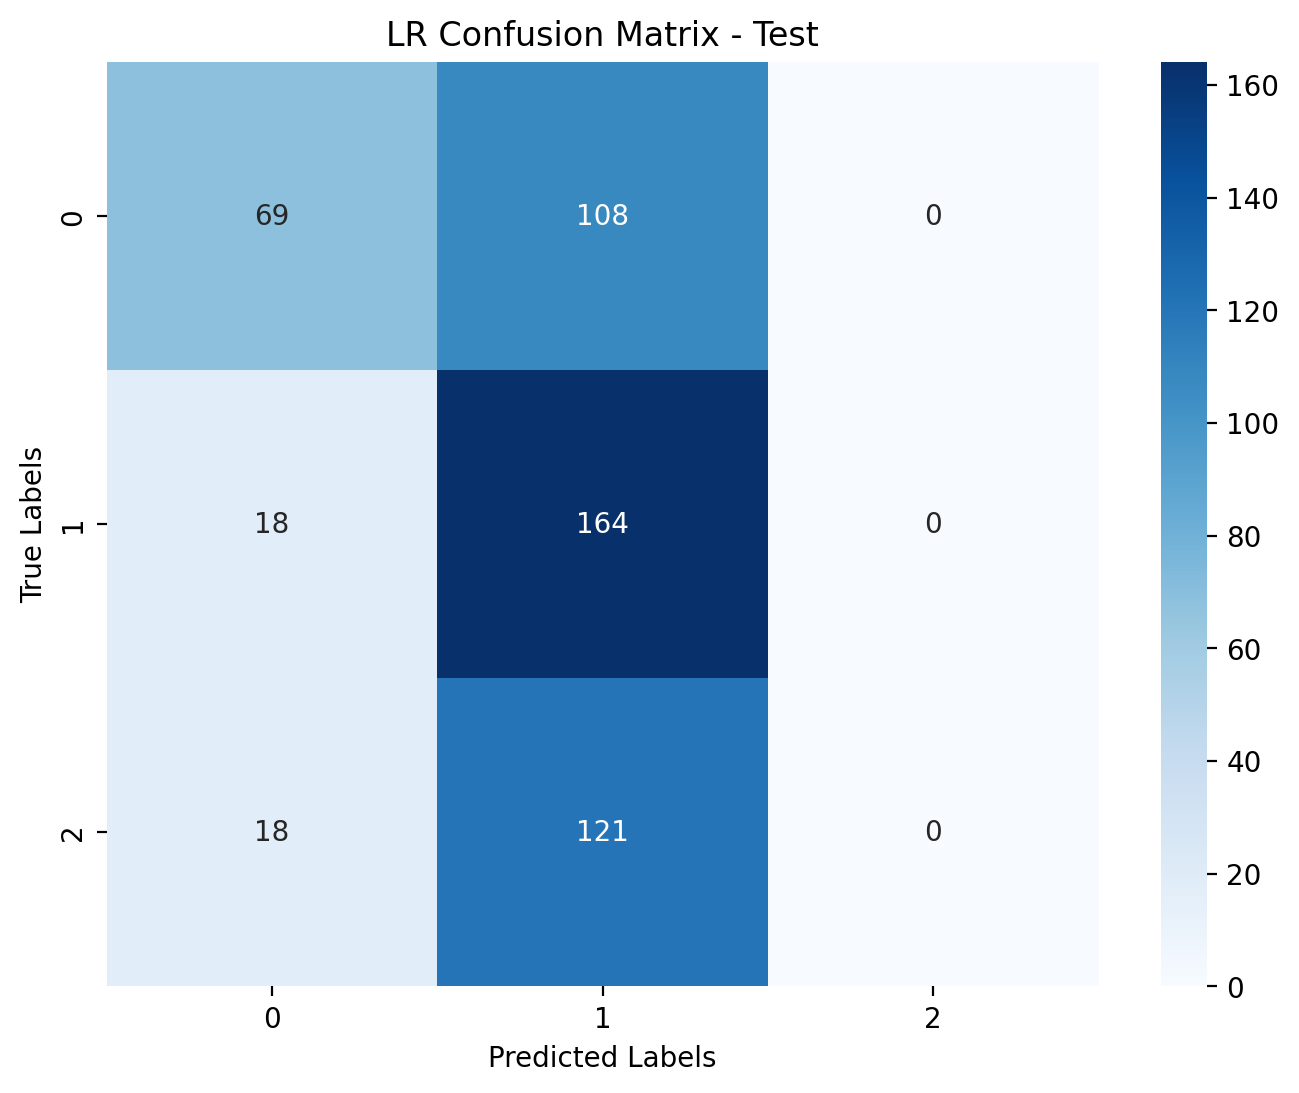

In [ ]:
# Compute the confusion matrix
cm =  confusion_matrix(Y_test, Y_test_pred)

# Get class labels
classes = np.unique(np.concatenate((Y_test, Y_test_pred)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LR Confusion Matrix - Test')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

Othe of the main issues in the work is the fact that I have to try to predict the neutral label without seeing it in the training set. This is a difficult problem if I don't have the chance to make data augmentation or use a pretrianed model with 3 classes. That would be the ideal tool to implement.

However, I could try to set the third label, 2, to the samples with more uncertainty, for example with probabilities between 0.45 and 0.55, that result to be the less clear in the prediction.

In [ ]:
probs = LR_with_CV_tfidf.predict_proba(tfidf_dense_test)[:, 0]
neutral_indexs = np.where(np.logical_and(probs <= 0.55, probs >= 0.45))

Y_test_pred = LR_with_CV_tfidf.predict(tfidf_dense_test)
Y_test_pred[neutral_indexs] = 2

In [ ]:
# Compute accuracy
accuracy = accuracy_score(Y_test, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.4578313253012048
F1 Score: 0.4578313253012048
Recall: 0.4578313253012048
Precision: 0.4578313253012048


([<matplotlib.axis.YTick at 0x7fe1086f0be0>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

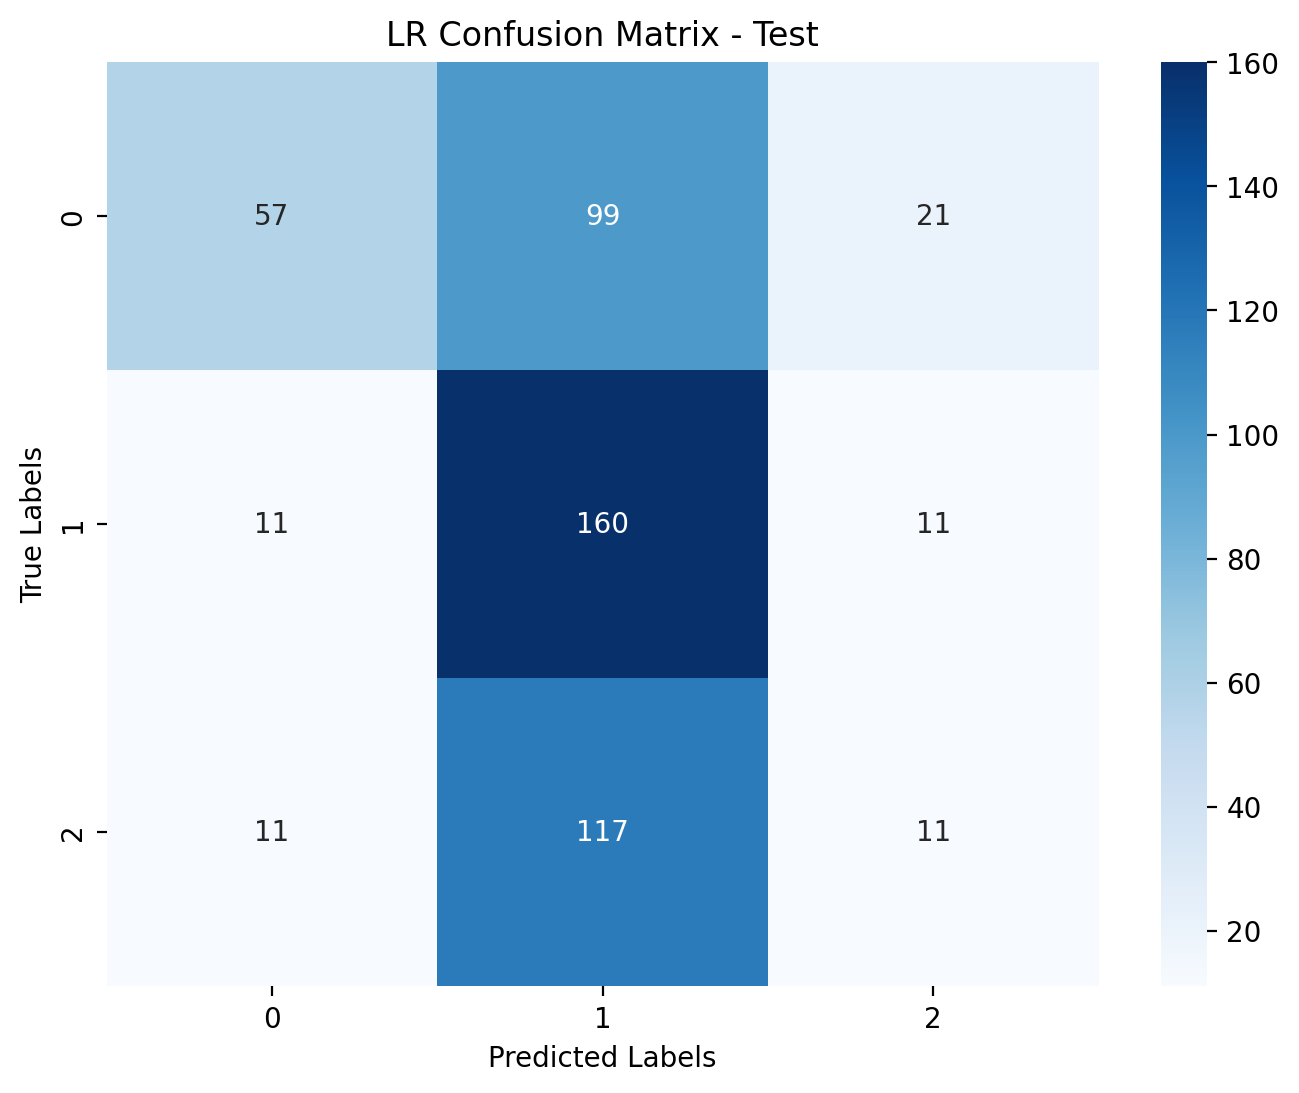

In [ ]:
# Compute the confusion matrix
cm =  confusion_matrix(Y_test, Y_test_pred)

# Get class labels
classes = np.unique(np.concatenate((Y_test, Y_test_pred)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('LR Confusion Matrix - Test')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

As we see in the confusion matrix, the results did not improve cause I increase the correct predictions in label 2 but they decrease in the others. Consequently, the scores decrease.

#### 3.2.2. Evaluation in test-dublin set

I repeat the metrics in the other test set.

In [ ]:
Y_test_pred = LR_with_CV_tfidf.predict(tfidf_dense_test_dublin)

# Compute accuracy
accuracy = accuracy_score(Y_test_dublin, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test_dublin, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.382
F1 Score: 0.382
Recall: 0.382
Precision: 0.382


They are even worse since this is a out-of-domain data set, very differnt from the training one.

In [ ]:
probs = LR_with_CV_tfidf.predict_proba(tfidf_dense_test_dublin)[:, 0]
neutral_indexs = np.where(np.logical_and(probs <= 0.55, probs >= 0.45))

Y_test_pred = LR_with_CV_tfidf.predict(tfidf_dense_test_dublin)
Y_test_pred[neutral_indexs] = 2

In [ ]:
# Compute accuracy
accuracy = accuracy_score(Y_test_dublin, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test_dublin, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.36533333333333334
F1 Score: 0.36533333333333334
Recall: 0.36533333333333334
Precision: 0.36533333333333334


([<matplotlib.axis.YTick at 0x7fe1081e9d20>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

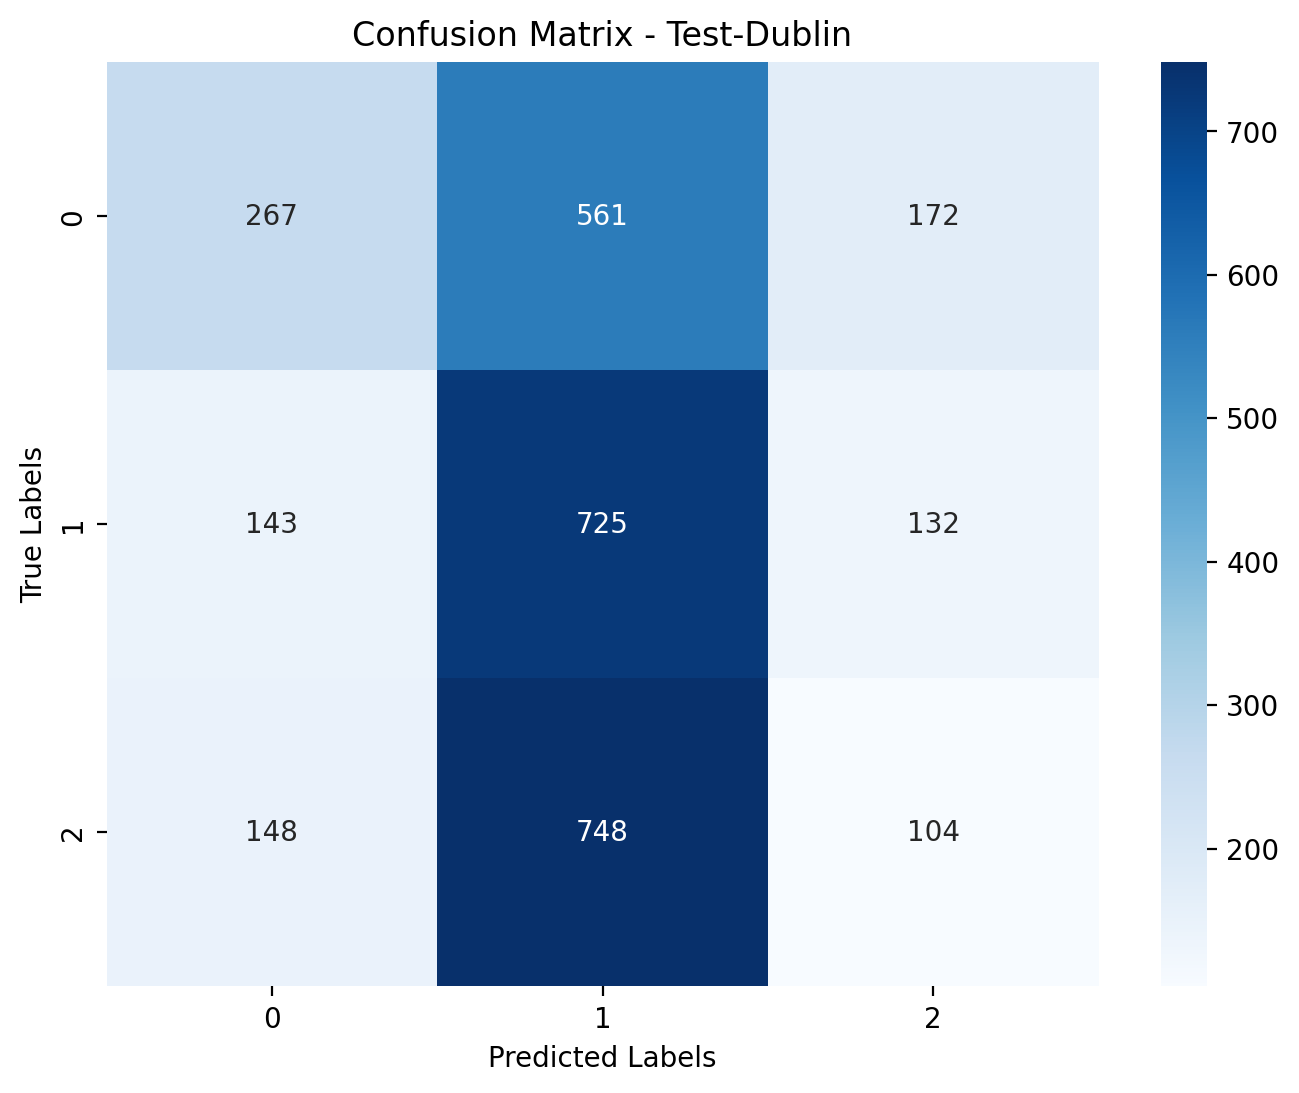

In [ ]:
# Compute the confusion matrix
cm =  confusion_matrix(Y_test_dublin, Y_test_pred)

# Get class labels
classes = np.unique(np.concatenate((Y_test_dublin, Y_test_pred)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test-Dublin')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

#### 3.2.3. Other metrics

Next, we plot the ROC curve.

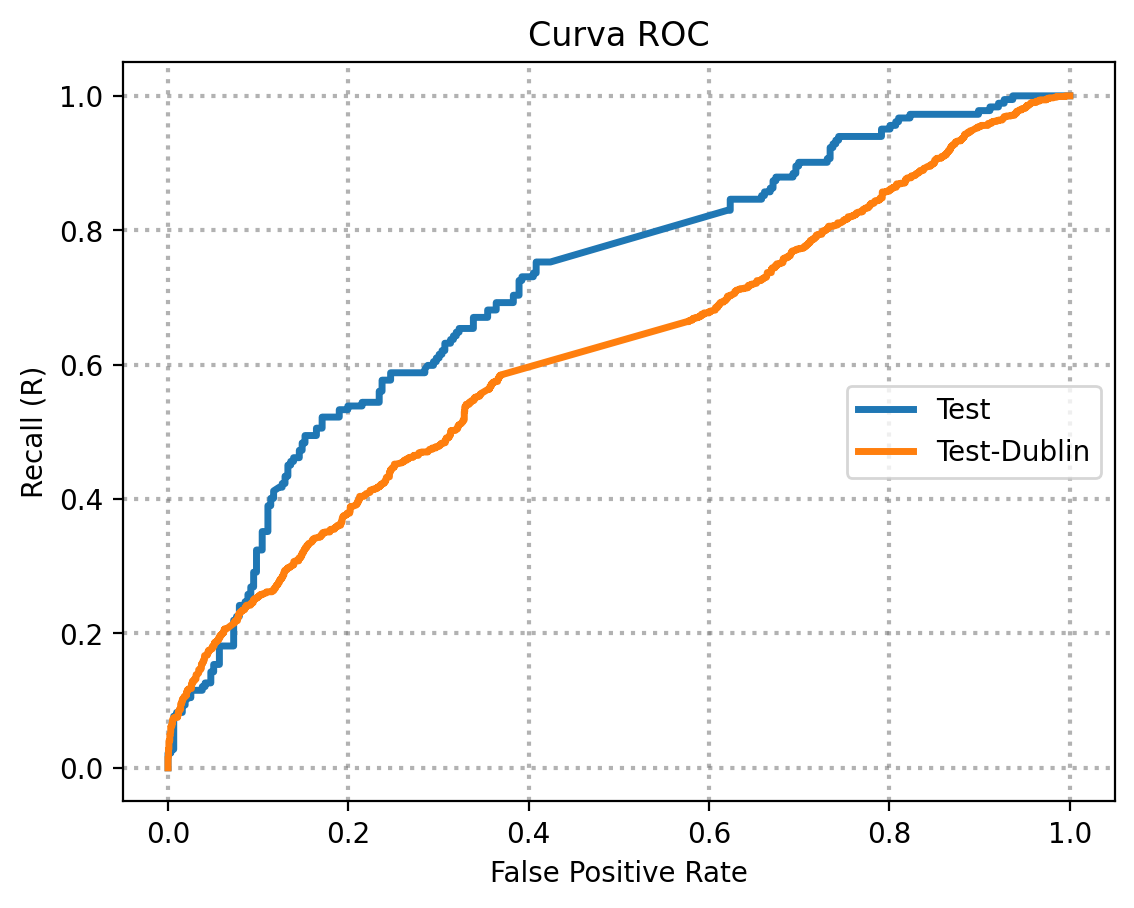

In [ ]:
fpr, recall, thresholds = metrics.roc_curve(Y_test, LR_with_CV_tfidf.predict_proba(tfidf_dense_test)[:,1], pos_label=1)
fpr2, recall2, thresholds = metrics.roc_curve(Y_test_dublin, LR_with_CV_tfidf.predict_proba(tfidf_dense_test_dublin)[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Test')
plt.plot(fpr2,recall2,lw=2.5,label='Test-Dublin')
plt.legend(loc=7)
plt.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()


The blue curve is better since it is closer to the left side and the area under it is higher. It was expected cause that test set is more similar to the training data.

All the results are quite bad, maybe due to the small subset of samples I have taken to speed up the experiments. Ideally, I should use all samples in training with a complete stage in the cross validation exploration.

### 3.3. Classification model: SVM

Here I repeat the same experiments but with a SVM.

Again, ideally, it is better to perform a cross-validation strategy with a smaller step in the exploration range of the hiperparameters. However, due to time and resources limitation, we are keeping it simple.

In [ ]:
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
nfold = 5 # Number of folds in the cross-validation process

""" Adjust hiperparameters by CV"""
SVM_with_CV_tfidf  = GridSearchCV(estimator=SVC(probability=True), param_grid=param_grid, cv=nfold)

# Train the model
SVM_with_CV_tfidf.fit(tfidf_dense_train, Y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [ ]:
# Classification score train/test
accuracy_train = SVM_with_CV_tfidf.score(tfidf_dense_train, Y_train)
accuracy_test = SVM_with_CV_tfidf.score(tfidf_dense_test, Y_test)
accuracy_test_dublin = SVM_with_CV_tfidf.score(tfidf_dense_test_dublin, Y_test_dublin)

print("Accuracy train {0:.2f}%. Accuracy test {1:.2f}%. Accuracy test Dublin {2:.2f}%\n".format(accuracy_train*100, accuracy_test*100, accuracy_test_dublin*100))

Accuracy train 92.70%. Accuracy test 46.39%. Accuracy test Dublin 38.23%



In [ ]:
print("Best Parameters:", SVM_with_CV_tfidf.best_params_)

Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
Y_test_pred = SVM_with_CV_tfidf.predict(tfidf_dense_test)

# Compute accuracy
accuracy = accuracy_score(Y_test, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.463855421686747
F1 Score: 0.463855421686747
Recall: 0.463855421686747
Precision: 0.463855421686747


([<matplotlib.axis.YTick at 0x7fe107d26a10>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

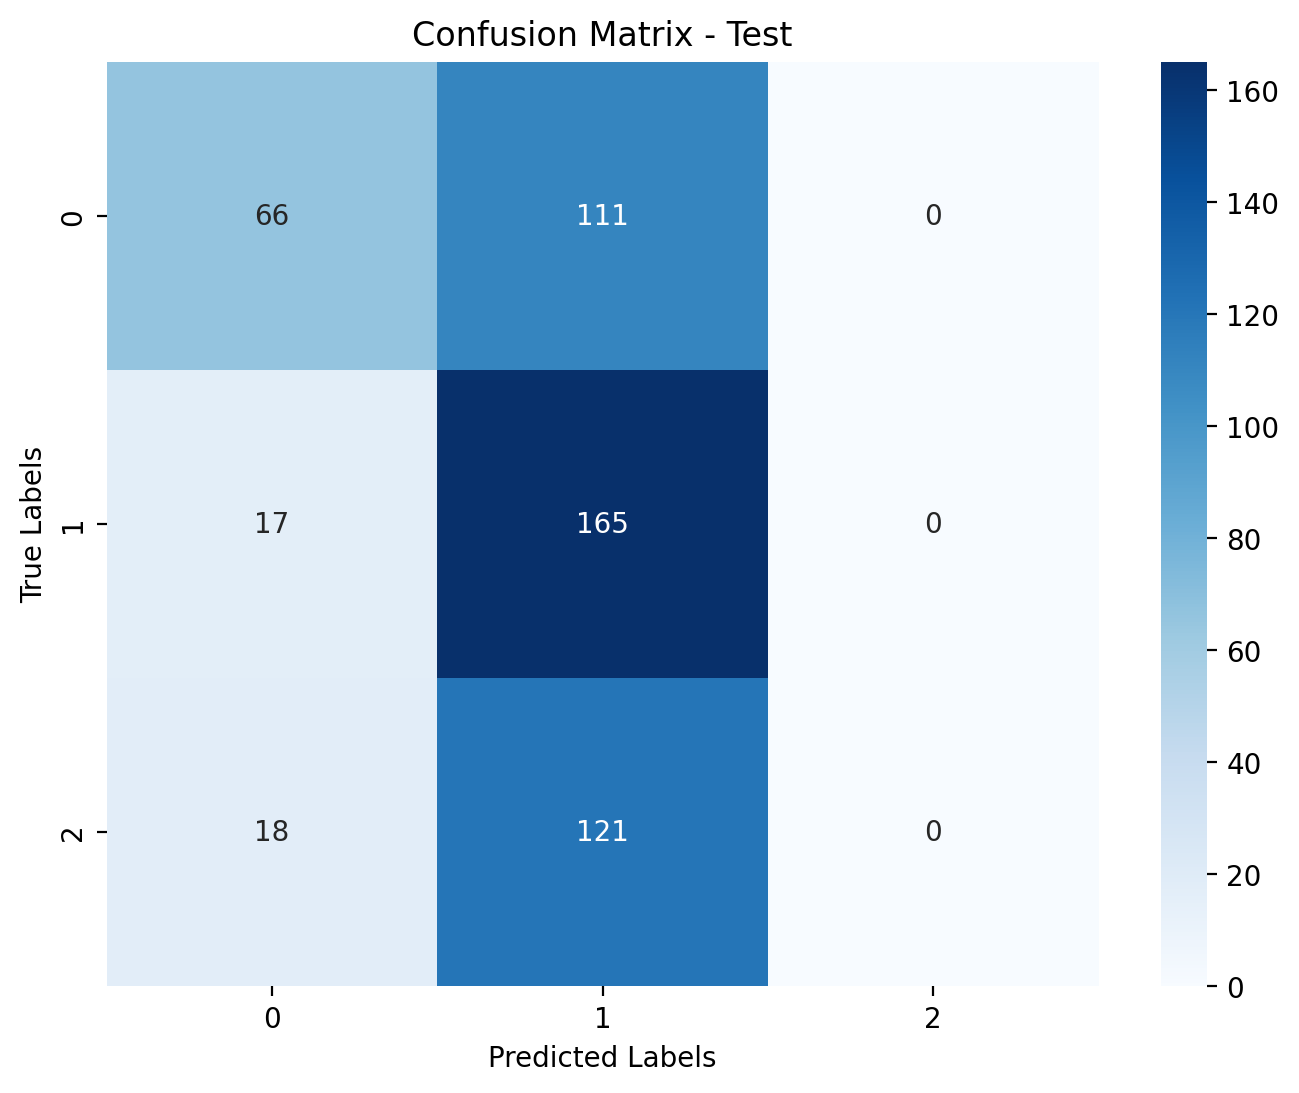

In [ ]:
probs = SVM_with_CV_tfidf.predict(tfidf_dense_test)

# Compute the confusion matrix
cm =  confusion_matrix(Y_test, probs)

# Get class labels
classes = np.unique(np.concatenate((Y_test, probs)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

In [ ]:
Y_test_pred = SVM_with_CV_tfidf.predict(tfidf_dense_test_dublin)

# Compute accuracy
accuracy = accuracy_score(Y_test_dublin, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test_dublin, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test_dublin, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.38233333333333336
F1 Score: 0.38233333333333336
Recall: 0.38233333333333336
Precision: 0.38233333333333336


([<matplotlib.axis.YTick at 0x7fe107ff2920>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

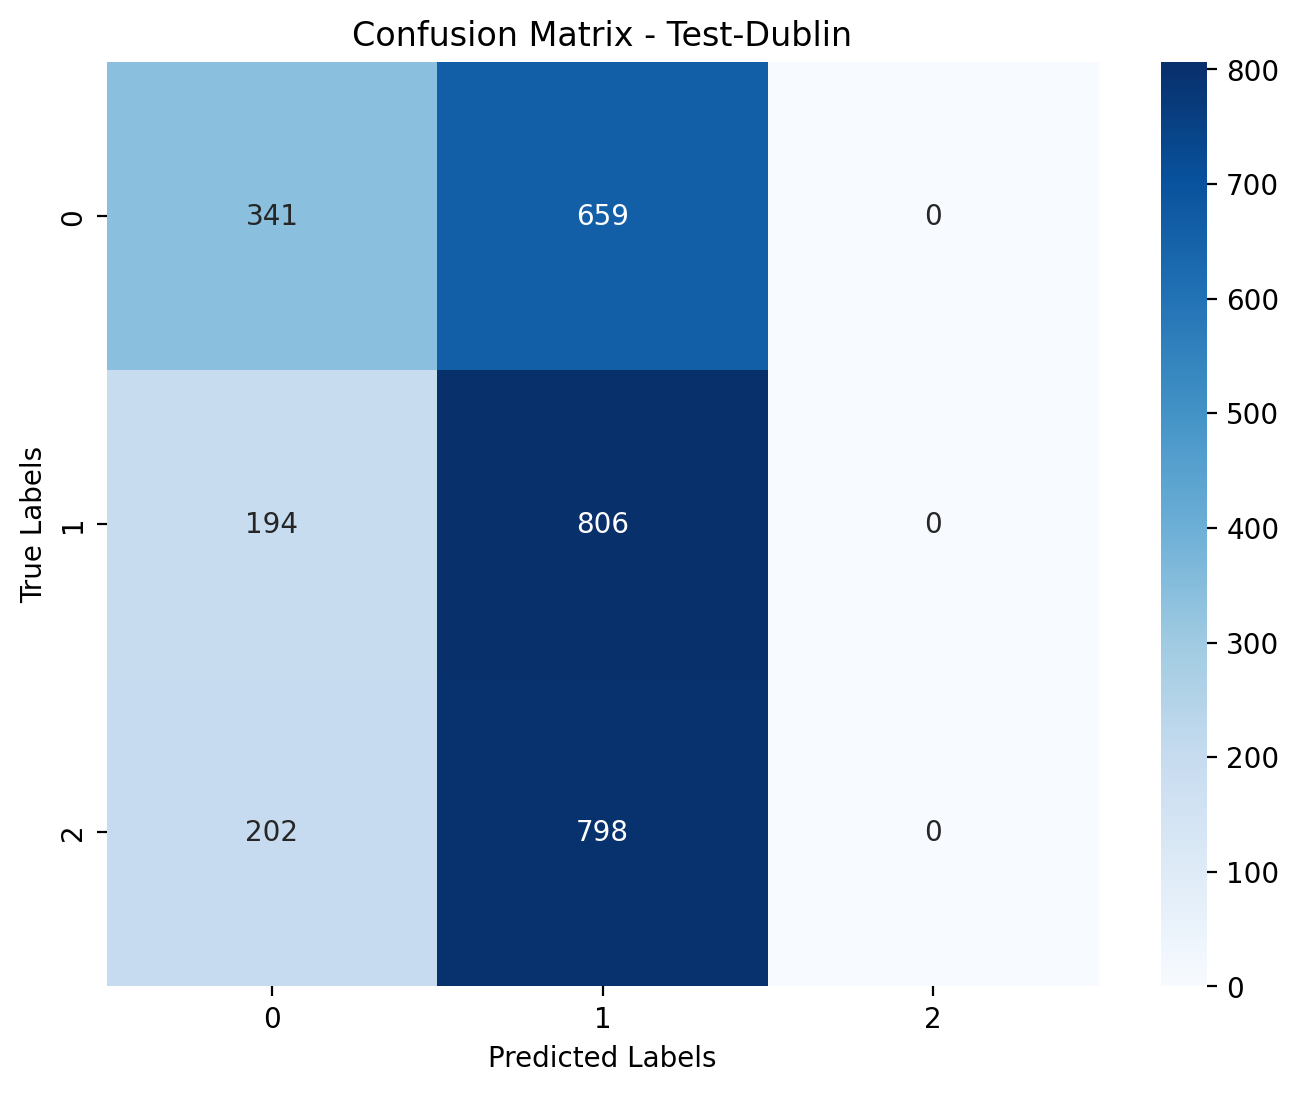

In [ ]:
# Compute the confusion matrix
cm =  confusion_matrix(Y_test_dublin, Y_test_pred)

# Get class labels
classes = np.unique(np.concatenate((Y_test_dublin, Y_test_pred)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test-Dublin')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

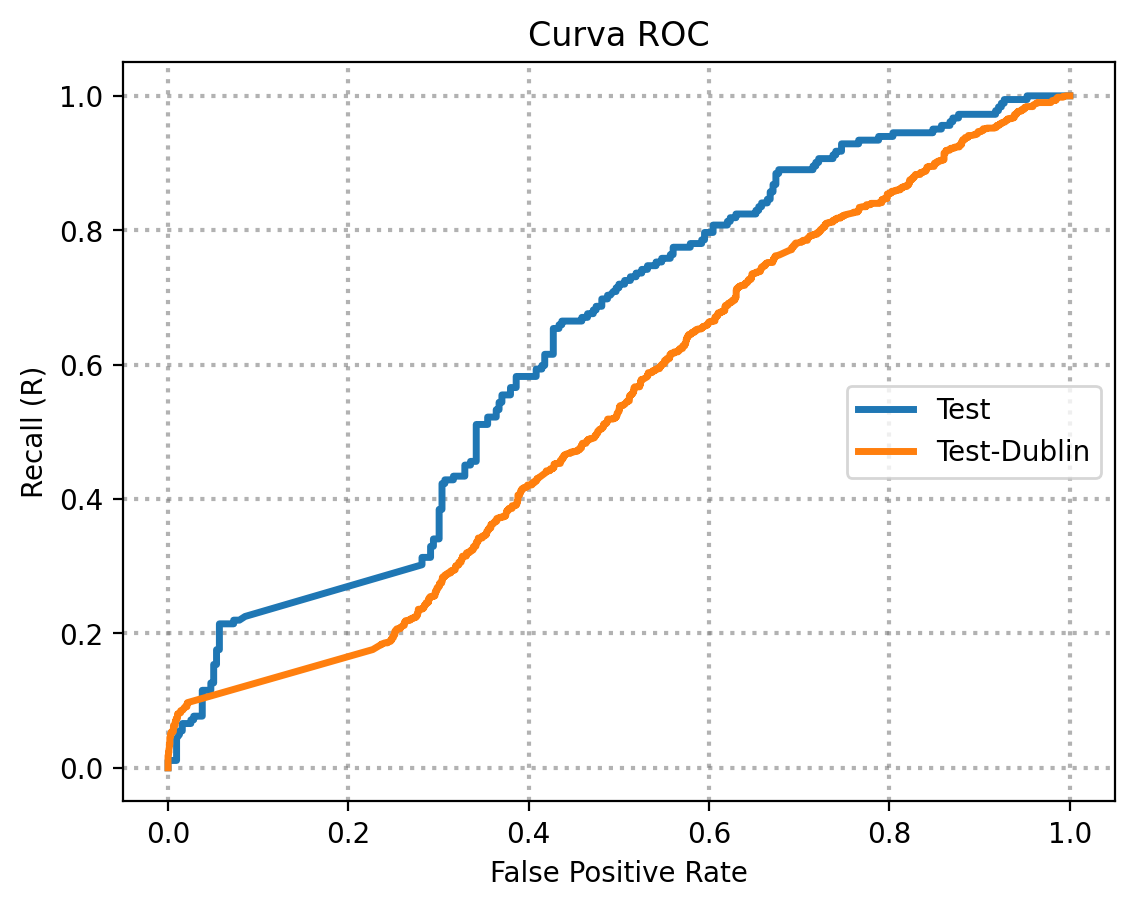

In [ ]:
fpr, recall, thresholds = metrics.roc_curve(Y_test, SVM_with_CV_tfidf.predict_proba(tfidf_dense_test)[:,1], pos_label=1)
fpr2, recall2, thresholds = metrics.roc_curve(Y_test_dublin, SVM_with_CV_tfidf.predict_proba(tfidf_dense_test_dublin)[:,1], pos_label=1)

fig,ax = plt.subplots()
plt.plot(fpr,recall,lw=2.5,label='Test')
plt.plot(fpr2,recall2,lw=2.5,label='Test-Dublin')
plt.legend(loc=7)
plt.grid(visible=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('Recall (R)')
plt.title('Curva ROC')
plt.show()


We try same strategy as before with the third label.

In [ ]:
probs = SVM_with_CV_tfidf.predict_proba(tfidf_dense_test)[:, 0]
neutral_indexs = np.where(np.logical_and(probs <= 0.55, probs >= 0.45))

Y_test_pred = SVM_with_CV_tfidf.predict(tfidf_dense_test)
Y_test_pred[neutral_indexs] = 2

([<matplotlib.axis.YTick at 0x7fe108cca410>,
 [Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')])

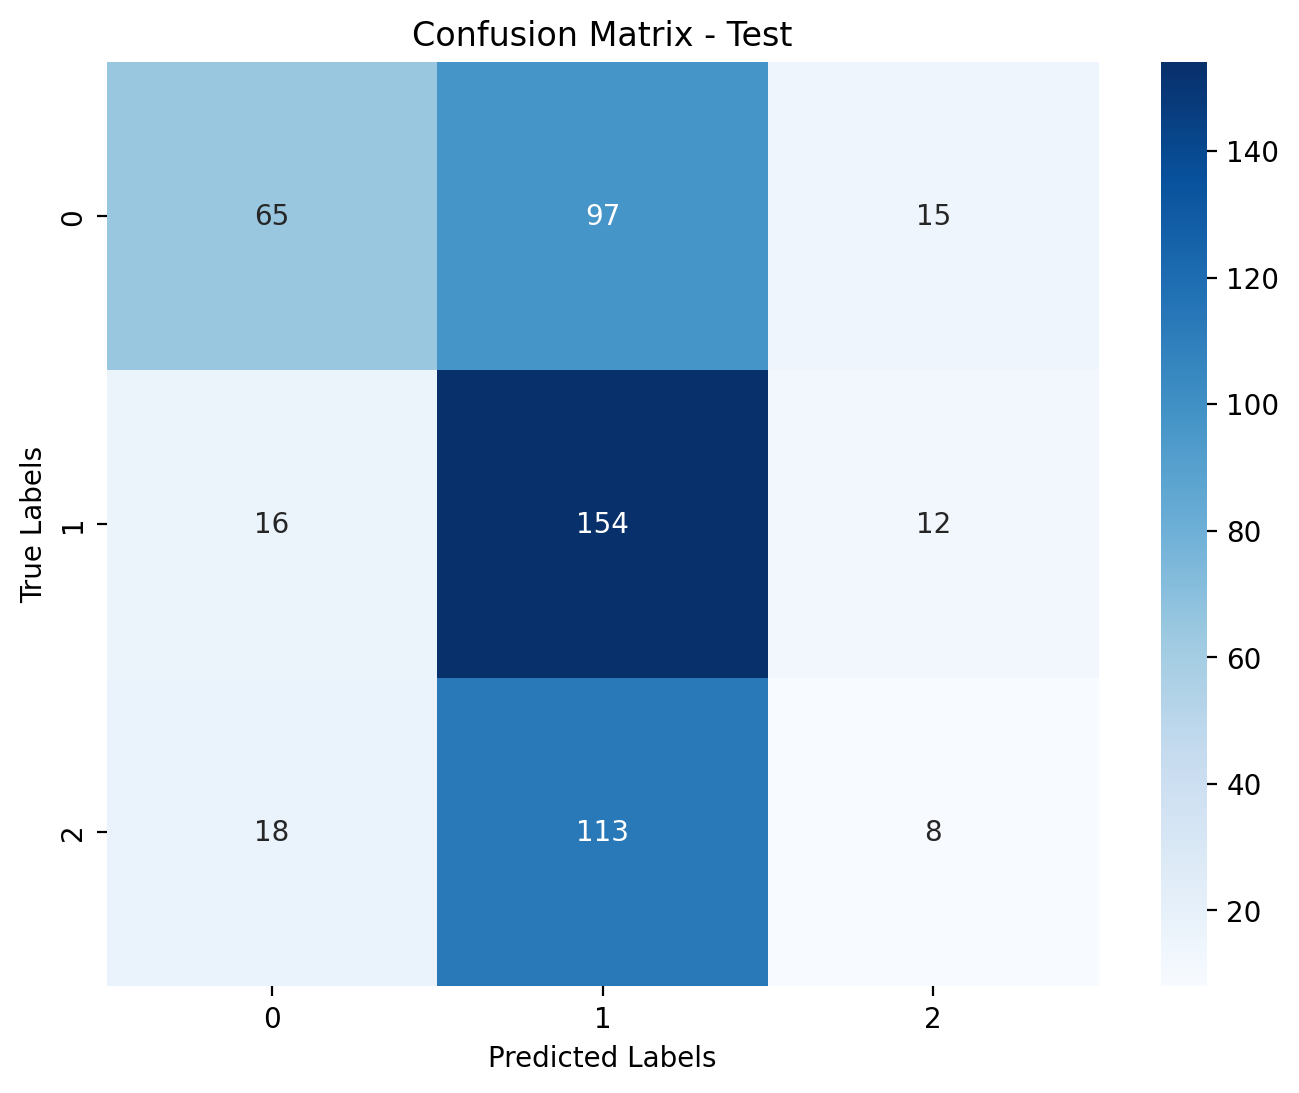

In [ ]:
# Compute the confusion matrix
cm =  confusion_matrix(Y_test, Y_test_pred)

# Get class labels
classes = np.unique(np.concatenate((Y_test, Y_test_pred)))
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test')
plt.xticks(np.arange(len(classes))+0.5, classes)
plt.yticks(np.arange(len(classes))+0.5, classes)

As we see in the confusion matrix, the results did not improve cause I increase the correct predictions in label 2 but they decrease in the others.

#### 3.3.1. Categories in test-dublin

We have different categories data in the out of domain test data. And we can see that the model performance is better in determined categories than others. This is due that this dataset is very different from the training one, that may have data in a specific topic. Then using data from other dataset may differ a lot in the performance. However, if we filter this new dataset to topics more similar to the training data, the accuracy may improve.

Next, I expose the results regarding this exploration.

In [ ]:
category_test_dublin.value_counts()

Mobility                    669
Community and Culture       614
Housing                     258
Safety                      238
Poverty and Homelessness    236
Environment                 218
Infrastructure              153
Governance                  144
Tourism and Hospitality     120
Social Inclusion             79
Utilities                    74
Education                    69
Economic Development         50
Public Spaces                49
Health                       29
Name: category, dtype: int64

First, I filter the test data from the category 'Public Spaces' and compute the accuracy of the model.

In [ ]:
tfidf_dense_test_dublin_PS = tfidf_dense_test_dublin[category_test_dublin=='Public Spaces']
Y_test_dublin_PS = Y_test_dublin[category_test_dublin=='Public Spaces']

In [ ]:
Y_test_pred = SVM_with_CV_tfidf.predict(tfidf_dense_test_dublin_PS)

# Compute accuracy
accuracy = accuracy_score(Y_test_dublin_PS, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test_dublin_PS, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test_dublin_PS, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test_dublin_PS, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.20408163265306123
F1 Score: 0.20408163265306123
Recall: 0.20408163265306123
Precision: 0.20408163265306123


I repeat with the category 'Community and Culture'

In [ ]:
tfidf_dense_test_dublin_CC = tfidf_dense_test_dublin[category_test_dublin=='Community and Culture']
Y_test_dublin_CC = Y_test_dublin[category_test_dublin=='Community and Culture']

In [ ]:
Y_test_pred = SVM_with_CV_tfidf.predict(tfidf_dense_test_dublin_CC)

# Compute accuracy
accuracy = accuracy_score(Y_test_dublin_CC, Y_test_pred)

# Compute F1 score
f1 = f1_score(Y_test_dublin_CC, Y_test_pred, average='micro')

# Compute recall
recall = recall_score(Y_test_dublin_CC, Y_test_pred, average='micro')

# Compute precision
precision = precision_score(Y_test_dublin_CC, Y_test_pred, average='micro')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.4511400651465798
F1 Score: 0.4511400651465798
Recall: 0.4511400651465798
Precision: 0.4511400651465798


The results in this second category are better so we could claim that the samples used in the training set are more related to this topic/category.

In [ ]:
X_test_dublin[category_test_dublin=='Community and Culture'].iloc[0]

'Love my city and community!! Rallying together for what is right ð\x9f\x91\x8fð\x9f\x8f½ð\x9f\x91\x8fð\x9f\x8f½ð\x9f\x91\x8fð\x9f\x8f½ð\x9f\x91\x8fð\x9f\x8f½ @selenatwest @NinaWest \n\nSupporters rally outside Delaware Drag 101 class https://t.co/sCNRDZ9cvp'

In [ ]:
X_test_dublin[category_test_dublin=='Public Spaces'].iloc[0]

'@DanMulhall @EamonnMallie @MoLI_Museum .@DubCityCouncil #parks dept does great job all year round. Grma - I regularly walk through St Stephenâ\x80\x99s Green &amp; am always grateful #Dublin'

In [ ]:
X_train.iloc[799000]

"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T "

## 4. Neural model: BERT

### 4.1 Data preparation

With a transformer tokenizer and embedding creation, it is not neccesary to clean the data manually. In the contrary, I will take advantage of a pretrained model from *hugging face* library. I will use a basic model, *bert-base-uncased*, but the ideal strategy would be to use a pretrained model in a dataset related to our data.

Firtly, we will split the data and take a small subset due to resoruces limitations as before. We take the same subset so it it fair to compare the performance with the baseline.

In [17]:
Y_train = Y_train.iloc[799000:801000] # limitation to being able to compute with the limited resources I have
X_train = X_train.iloc[799000:801000] # limitation to being able to compute with the limited resources I have

In [18]:
bert_model_name = 'bert-base-uncased'

In [19]:
df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis=1)
df.columns = ['text', 'label']
df

,text,label
799000,"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I...",0
799001,Charlie lost an angel today Very sad http:...,0
799002,"at work, and very bored",0
799003,It's weird how celebrities go in threes. Carra...,0
799004,@adelate Farrah's dead? Had no idea.. RIP Farr...,0
...,...,...
800995,I have this strange desire to go to confession...,1
800996,@i_reporter answer sent in dm. try it,1
800997,@brooklynunion cuz ur 3pm is my 9am and Id be ...,1
800998,@littrellfans Its all good. Just figured you w...,1


I will split the data in train and validation so I can make use of early stopping strategies in the training, and also fine the best set of hiperparameters. Again, I do not make a huge exploration in the hiperparameters as it would be ideally done.

In [20]:
# Split the data in train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

The next class defines a dataset type to load the samples and use in conjuntion with the transformers and pytorch library in the training algorithm.

In [21]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        label = self.data.iloc[index]['label']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

Before feeding the neural model, it is necessary to make a tokenizer step to convert the sentences in vectors. We use the same pretrained model as in the NN architecture.

In [22]:
# Set the tokenizer and maximum sequence length
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
max_length = 128

# Create the custom train and validation datasets
train_dataset = CustomDataset(train_df, tokenizer, max_length)
val_dataset = CustomDataset(val_df, tokenizer, max_length)

# Set the batch size
batch_size = 32

*DataLoader* is a pytorch class to create minibatches for the training algorithm.

In [23]:
# Create train and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## 4.2. Model creation

The model proposed in the assignment for this step is composed of a transformer-like BERT and a RNN followed of a linear layer.

It would be also possible to use a Transformer structure by itself with a classification layer.

The network proposed is just one of the many variants it would be possible to try. In researching, it is better to explore more options because sometimes you do not know a priori what is going to work the best. In a similar way, you can also try different optimization algoritms, not only Adam as it is used, and configuration hiperparameter or regularization techniques. But, this is a basic model that works fine as it is seen in the accuracy so I keep this exploration for the future.


Mainly, see the 3 main blocks in the following definition:
- BERT as the transformer layer to create embeddings: I only use the pooled output from the last encoder layer.
- LSTM as the recurrent structure that crete the sentence-level input representations. You may try a bidirectional structure or non.
- Last layer, a dense network, to obtain an output with as many dimensions as classes, in this case 2.
- Probability output for each class is obtain with the non-linear function logsoftmax.


In [24]:
class Encoder_BERT_LSTM(nn.Module):
    def __init__(self, bert_size, hidden_size, num_classes, num_layers, drop_prob, bidirectional=False, bert_model_name='bert-base-uncased'):
        super().__init__()

        self.bert_size = bert_size

        self.hidden_size = hidden_size

        self.num_classes = num_classes

        self.num_layers = num_layers

        self.drop_prob = drop_prob

        self.num_directions = 2 if bidirectional else 1

        self.bert = BertModel.from_pretrained(bert_model_name)

        # Define a RNN with the specified parameters
        self.lstm = nn.LSTM(bert_size, hidden_size, num_layers, dropout=drop_prob, batch_first=True, bidirectional=bidirectional)        # batch_first=True means that the first dimension of the input will be the batch_size

        # Last, fully-connected layer
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, attention_mask):
        '''
        About the shape of the different tensors ...:
        - Input signal x has shape (batch_size, seq_length, bert_size)
        - The initialization of the LSTM hidden state is a tuple, containing two tensors of dimensions
          (n_layers, batch_size, hidden_dim) each. The first tensor represents the LSTM hidden state
          cell states. We can use the None value so internally they are initialized with 0s.
        - The LSTM output shape is (batch_size, seq_length, hidden_size)
        '''

        bert_output = self.bert(input_ids, attention_mask)

        pooler_output = bert_output['pooler_output']
        encoded_output, _ = self.lstm(pooler_output.unsqueeze(1))

        # Select the output from the last hidden state
        # output = output.reshape(-1, self.hidden_dim)
        encoded_output = encoded_output[:, -1, :]

        # Perform the fully conected layer step
        logits = self.fc(encoded_output)

        # Apply the softmax layer to compute probabilities
        softmax = self.logsoftmax(logits)


        return softmax


The next class is created to train and evaluate the deep learning model defined before.

In [30]:
class Encoder_LSTM_extended(Encoder_BERT_LSTM):

    def __init__(self, num_epochs, sequence_length, bert_size, hidden_size, num_classes, num_layers, device, drop_prob=0.3, bidirectional=False, bert_model_name='bert-base-uncased', lr=0.001):

        super().__init__(bert_size, hidden_size, num_classes, num_layers, drop_prob, bidirectional, bert_model_name)

        self.hidden_size = hidden_size

        self.sequence_length = sequence_length

        self.num_layers = num_layers

        self.lr = lr #Learning Rate

        self.optimizer = torch.optim.Adam(self.parameters(), self.lr)

        self.num_epochs = num_epochs

        self.criterion = nn.CrossEntropyLoss()

        # A list to store the training loss evolution along training
        self.loss_during_training = []
        # A list to store the validation loss evolution along training
        self.valid_loss_during_training = []

        self.device = device

        self.to(self.device)

        self.name_model = '{}epochs_{}lr_{}layers_{}hiddensize_bidirectional'.format(num_epochs, lr, num_layers, hidden_size) if bidirectional else '{}epochs_{}lr_{}layers_{}hiddensize'.format(num_epochs, lr, num_layers, hidden_size)


    def trainloop(self, train_loader, val_loader):


        best_val_loss = float('inf')

        # Optimization Loop
        for e in range(int(self.num_epochs)):
            self.train()
            running_loss = 0.
            for batch in train_loader:
                input_ids_batch = batch['input_ids'].to(self.device)
                attention_mask_batch = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Reset the gradients
                self.optimizer.zero_grad()

                outputs = self.forward(input_ids_batch, attention_mask_batch)

                loss = self.criterion(outputs, labels)

                running_loss += loss.item()

                loss.backward()


                self.optimizer.step()

            self.loss_during_training.append(running_loss/len(train_loader))


            correct = 0
            total = 0
            with torch.no_grad():
                # set model to evaluation mode
                self.eval()
                running_loss = 0.
                for batch in val_loader:
                    input_ids_batch = batch['input_ids'].to(self.device)
                    attention_mask_batch = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.forward(input_ids_batch, attention_mask_batch)

                    loss = self.criterion(outputs, labels)

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                self.valid_loss_during_training.append(running_loss/len(val_loader))

                if self.valid_loss_during_training[-1] < best_val_loss:
                  best_val_loss = self.valid_loss_during_training[-1]
                  # Save the model state
                  torch.save(self.state_dict(), path_models + 'best_model_{}.pth'.format(self.name_model))

            if(e % 10 == 0): # Every 10 epochs
                print("Epoch %d. Training loss: %f, Validation loss: %f"
                      %(e+1, self.loss_during_training[-1], self.valid_loss_during_training[-1]))

            accuracy = 100 * correct / total
            print(f'Epoch {e+1}/{self.num_epochs}, Validation accuracy: {accuracy:.2f}%')


## 4.3. Training

Finally, the training step would be composed of several experiments to fin the best hiperparameter and configuration. Here there are some examples.

In [26]:
# Use the GPU if it is possible to speed up the training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 4.3.1. Experiment 1

In [27]:
num_epochs = 20
num_classes = 2
num_layers = 3
bert_size = 768
hidden_size = 128
lr = 1e-5
bidirectional = False

my_Encoder_LSTM = Encoder_LSTM_extended(num_epochs, max_length, bert_size, hidden_size, num_classes, num_layers, device, drop_prob=0.3, bidirectional=bidirectional, lr=lr, bert_model_name=bert_model_name)

my_Encoder_LSTM.trainloop(train_loader, val_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1. Training loss: 0.692370, Validation loss: 0.690416
Epoch 1/20, Validation accuracy: 49.75%
Epoch 2/20, Validation accuracy: 49.75%
Epoch 3/20, Validation accuracy: 82.25%
Epoch 4/20, Validation accuracy: 85.25%
Epoch 5/20, Validation accuracy: 84.25%
Epoch 6/20, Validation accuracy: 85.00%
Epoch 7/20, Validation accuracy: 85.75%
Epoch 8/20, Validation accuracy: 83.75%
Epoch 9/20, Validation accuracy: 83.75%
Epoch 10/20, Validation accuracy: 86.25%
Epoch 11. Training loss: 0.454190, Validation loss: 0.516689
Epoch 11/20, Validation accuracy: 84.25%
Epoch 12/20, Validation accuracy: 85.50%
Epoch 13/20, Validation accuracy: 85.00%
Epoch 14/20, Validation accuracy: 85.00%
Epoch 15/20, Validation accuracy: 84.75%
Epoch 16/20, Validation accuracy: 85.00%
Epoch 17/20, Validation accuracy: 85.75%
Epoch 18/20, Validation accuracy: 84.25%
Epoch 19/20, Validation accuracy: 85.25%
Epoch 20/20, Validation accuracy: 84.25%


### 4.3.2. Experiment 2

In [32]:
num_epochs = 20
num_classes = 2
num_layers = 3
bert_size = 768
hidden_size = 128
lr = 1e-5
bidirectional = True

my_Encoder_LSTM = Encoder_LSTM_extended(num_epochs, max_length, bert_size, hidden_size, num_classes, num_layers, device, drop_prob=0.3, bidirectional=bidirectional, lr=lr, bert_model_name=bert_model_name)

my_Encoder_LSTM.trainloop(train_loader, val_loader)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1. Training loss: 0.691972, Validation loss: 0.689184
Epoch 1/20, Validation accuracy: 49.75%
Epoch 2/20, Validation accuracy: 81.25%
Epoch 3/20, Validation accuracy: 83.75%
Epoch 4/20, Validation accuracy: 83.50%
Epoch 5/20, Validation accuracy: 84.75%
Epoch 6/20, Validation accuracy: 85.50%
Epoch 7/20, Validation accuracy: 85.75%
Epoch 8/20, Validation accuracy: 85.75%
Epoch 9/20, Validation accuracy: 85.75%
Epoch 10/20, Validation accuracy: 85.25%
Epoch 11. Training loss: 0.226228, Validation loss: 0.437969
Epoch 11/20, Validation accuracy: 84.00%
Epoch 12/20, Validation accuracy: 85.25%
Epoch 13/20, Validation accuracy: 86.50%
Epoch 14/20, Validation accuracy: 85.00%
Epoch 15/20, Validation accuracy: 81.75%
Epoch 16/20, Validation accuracy: 83.75%
Epoch 17/20, Validation accuracy: 84.50%
Epoch 18/20, Validation accuracy: 84.75%
Epoch 19/20, Validation accuracy: 84.75%
Epoch 20/20, Validation accuracy: 83.75%


### 4.3.3. Evaluation in validation and test sets.

Finally, we will compute the metrics to evaluate the model performance and compare it with the baseline.

In [52]:
def accuracy_cnn(dataloader, model):
    model.to('cpu')
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        accuracy = 0.
        correct = 0
        total = 0
        for batch in dataloader:
            input_ids_batch = batch['input_ids']
            attention_mask_batch = batch['attention_mask']
            labels = batch['labels']

            outputs = model.forward(input_ids_batch, attention_mask_batch)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return 100 * correct / total

In [53]:
print(f"Train accuracy {accuracy_cnn(train_loader, my_Encoder_LSTM )}")
print(f"Validation accuracy {accuracy_cnn(val_loader, my_Encoder_LSTM )}")

Train accuracy 98.0625
Test accuracy 83.75


As I did with the training sets, it is neccesary to prepare also the test sets.

In [57]:
df_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis=1)
df_test.columns = ['text', 'label']

df_test_dublin = pd.concat([pd.DataFrame(X_test_dublin), pd.DataFrame(Y_test_dublin)], axis=1)
df_test_dublin.columns = ['text', 'label']

# Create the custom test datasets
test_dataset = CustomDataset(df_test, tokenizer, max_length)
test_dublin_dataset = CustomDataset(df_test_dublin, tokenizer, max_length)

# Create test  data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_dublin_loader = DataLoader(test_dublin_dataset, batch_size=batch_size)

Here, the accuracy decrease a lot regarding the training set, but remember we have 3 classes instead of 2 for these sets.

In [58]:
print(f"Test accuracy {accuracy_cnn(test_loader, my_Encoder_LSTM )}")
print(f"Test dublin accuracy {accuracy_cnn(test_dublin_loader, my_Encoder_LSTM )}")

Test accuracy 61.44578313253012
Test dublin accuracy 46.166666666666664


Another thing it is important to make before computing all evaluation metrics is to load the best model. You can see that the model start overfitting during triang at some point, for example here around epoch 10.

Then, I use early stopping to save the best model duirng training, that is the one with the lower validation loss.

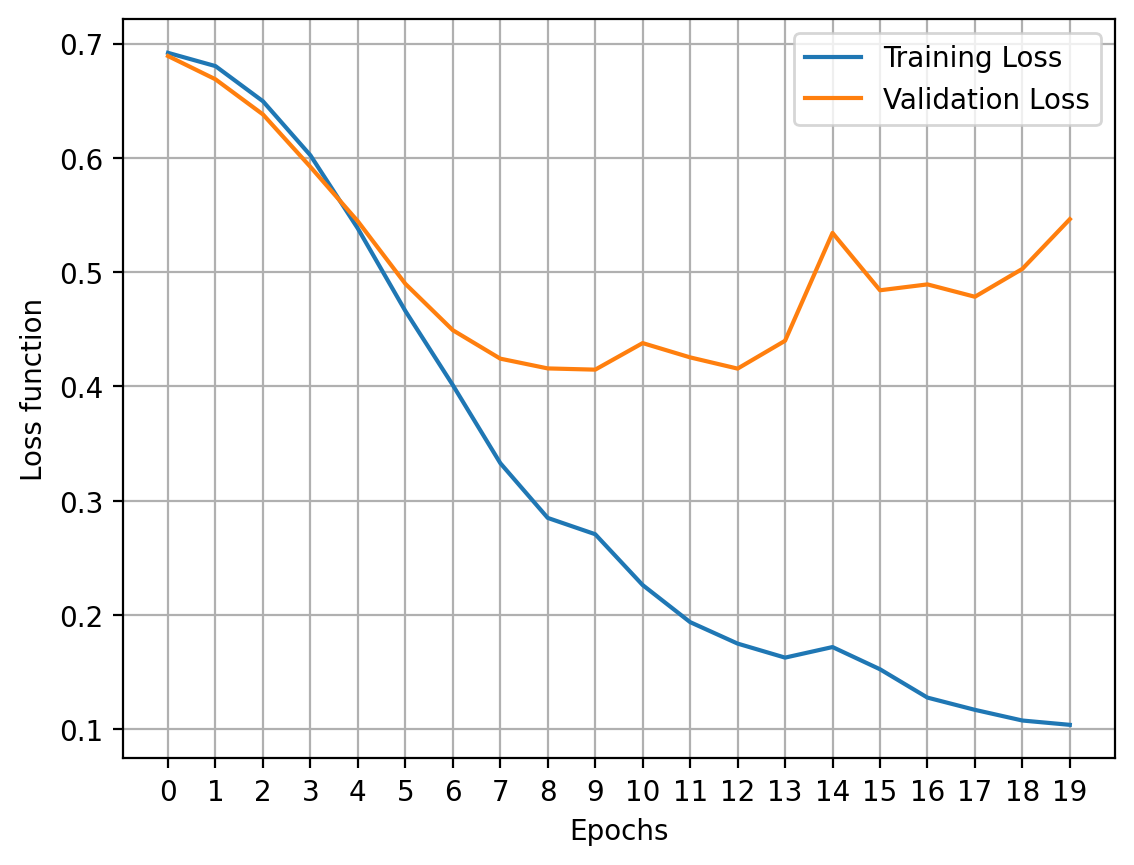

In [61]:
plt.plot(my_Encoder_LSTM.loss_during_training, label='Training Loss')
plt.plot(my_Encoder_LSTM.valid_loss_during_training, label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 20))
plt.ylabel('Loss function')
plt.legend()

Now, you can load the model and finish all the evaluation metrics.

In [62]:
my_Encoder_LSTM.load_state_dict(torch.load(path_models + 'best_model_20epochs_1e-05lr_3layers_128hiddensize_bidirectional.pth'))

<All keys matched successfully>

The following results are the accuracies for the best step in the training.

In [63]:
print(f"Train accuracy {accuracy_cnn(train_loader, my_Encoder_LSTM )}")
print(f"Validation accuracy {accuracy_cnn(val_loader, my_Encoder_LSTM )}")

Train accuracy 96.8125
Validation accuracy 85.25


Even though the training accuracy is a little worse, the validation accuracy improves, so that is a signal for being avoiding overfitting.

In [64]:
print(f"Test accuracy {accuracy_cnn(test_loader, my_Encoder_LSTM )}")
print(f"Test dublin accuracy {accuracy_cnn(test_dublin_loader, my_Encoder_LSTM )}")

Test accuracy 60.24096385542169
Test dublin accuracy 44.53333333333333


The step of computing other metric as beofre is kept for future, but we could also explore F1 score, confusion matrix, etc.

However, I am also going to explore the categories specified in the assignment and include the study of the errors in my model.

First, I am going to separate category smaples and compute the accuracy.

In [65]:
# Select the samples from the categories of interest
X_test_dublin_PS = X_test_dublin[category_test_dublin=='Public Spaces']
Y_test_dublin_PS = Y_test_dublin[category_test_dublin=='Public Spaces']
X_test_dublin_CC = X_test_dublin[category_test_dublin=='Community and Culture']
Y_test_dublin_CC = Y_test_dublin[category_test_dublin=='Community and Culture']

# Create the dataframes
df_test_dublin_PS = pd.concat([pd.DataFrame(X_test_dublin_PS), pd.DataFrame(Y_test_dublin_PS)], axis=1)
df_test_dublin_PS.columns = ['text', 'label']
df_test_dublin_CC = pd.concat([pd.DataFrame(X_test_dublin_CC), pd.DataFrame(Y_test_dublin_CC)], axis=1)
df_test_dublin_CC.columns = ['text', 'label']

# Create the custom test datasets
test_dublin_PS_dataset = CustomDataset(df_test_dublin_PS, tokenizer, max_length)
test_dublin_CC_dataset = CustomDataset(df_test_dublin_CC, tokenizer, max_length)

# Create test data loaders
test_dublin_PS_loader = DataLoader(test_dublin_PS_dataset, batch_size=batch_size)
test_dublin_CC_loader = DataLoader(test_dublin_CC_dataset, batch_size=batch_size)

In [66]:
print(f"Test Dublin 'Public Spaces' accuracy {accuracy_cnn(test_dublin_PS_loader, my_Encoder_LSTM )}")
print(f"Test Dublin 'Community and Culture' accuracy {accuracy_cnn(test_dublin_CC_loader, my_Encoder_LSTM )}")

Test Dublin 'Public Spaces' accuracy 32.6530612244898
Test Dublin 'Community and Culture' accuracy 52.11726384364821


As in the baseline model, the accuracy in CC category is better than in PS. However, in general, all metrics are better in the test sets with the NN model. This is due to the fact that this is a more complex models able to capture more difficult relations in the data.

Let's explore the errors.

**Errors in samples from PS category:**

In [68]:
my_Encoder_LSTM.to('cpu')
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    batch = next(iter(test_dublin_PS_loader))
    input_ids_batch = batch['input_ids']
    attention_mask_batch = batch['attention_mask']
    labels = batch['labels']

    outputs = my_Encoder_LSTM.forward(input_ids_batch, attention_mask_batch)

    _, predicted = torch.max(outputs.data, 1)
    incorrect = (predicted != labels)

In [94]:
examples = X_test_dublin_PS.iloc[:batch_size].values[incorrect]
predicted_label = predicted[incorrect].numpy()
real_label = labels[incorrect].numpy()
print('Real label - Predicted label - Text data')
for i, ex in enumerate(examples):
  print('{0:10} {1:10}            {2}'.format(real_label[i], predicted_label[i], ex.replace('\n', ' ')))

Real label - Predicted label - Text data
         0          1            It's Friday...relax your mind...enjoy nature ð  #Friday #relax #park #nature #green #stephensgreenpark #Dublin #City #Ireland #weekend @ St Stephen's Green https://t.co/EM0n5Florp
         0          1            Tomorrowâs outfit sorted ð â¦â¦@ilovestannesâ© â¦@AodhanORiordainâ© No high rise on our playing fields on the Avenue in St Anneâs Park â¦@DubCityCouncilâ© ð¦ 11.30 am. Be there. Also send observations before Tuesday to ABP https://t.co/gchgKqug1e
         0          1            @vitaminsludge @IrishPedestrian @DubCityCouncil @greenparty_ie @younggreens @dublincycling @DublinCommuters I think it's part of event control and Health &amp; Safety procedures (we used to have it at Electric Picnic &amp; also when I did site events at Guinness). Today is unfortunately still an event until there's proper pedestrianisation of the area. Once you have there won't be those signs.
         0       

**Errors in samples from CC category:**

In [95]:
my_Encoder_LSTM.to('cpu')
# Turn off gradients for validation, saves memory and computations
with torch.no_grad():

    batch = next(iter(test_dublin_CC_loader))
    input_ids_batch = batch['input_ids']
    attention_mask_batch = batch['attention_mask']
    labels = batch['labels']

    outputs = my_Encoder_LSTM.forward(input_ids_batch, attention_mask_batch)

    _, predicted = torch.max(outputs.data, 1)
    incorrect = (predicted != labels)

In [97]:
examples = X_test_dublin_CC.iloc[:batch_size].values[incorrect]
predicted_label = predicted[incorrect].numpy()
real_label = labels[incorrect].numpy()
print('Real label - Predicted label - Text data')
for i, ex in enumerate(examples):
  print('{0:10} {1:10}            {2}'.format(real_label[i], predicted_label[i], ex.replace('\n', ' ')))

Real label - Predicted label - Text data
         1          0            @pauldclynam @ChrisILbondo @LeoVaradkar This isnât about one pub closing, even though the Shaw is more than just a pub, itâs about the systematic destruction of every single artistic space in the city and itâs descent into a soulless boring kip filled with hotels and donut shops
         1          0            Please please PLEASE sign this. Galway city council are being absolute scumbags. They are stripping people of work, self expression AND one of the most impactful cultural aspects that is so attractive of the city! We can't let these wankers win! https://t.co/ZID5JFdgjP
         1          0            @CharlieFlanagan will you ask charlie  what community will want her if she is not even welcome in her own home town
         1          0            @alanoc8690 @KellyAnneByrne2 Show me a property owner who's rights are being infringed and I'll show you thousands of people who cannot live where they are